In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from scipy import stats as stats

In [324]:
data = pd.read_csv('GS1_ready_for_analysis.csv')

In [325]:
#looking at the columns
data.columns[0:35]

Index(['Unnamed: 0', 'Field Location', 'Source', 'PLOT ID', 'Genotype', 'Rep',
       'Plant Number', 'Trt', 'Growth Stage', 'SPADmeter', 'Ambient Humidity',
       'Ambient Pressure', 'Ambient Temperature', 'FmPrime', 'FoPrime', 'Fs',
       'FvP_over_FmP', 'Leaf Temperature', 'Leaf Temperature Differential',
       'leaf_thickness', 'LEF', 'NPQt', 'Phi2', 'PhiNO', 'PhiNPQ',
       'PS1 Active Centers', 'PS1 Open Centers', 'PS1 Over Reduced Centers',
       'PS1 Oxidized Centers', 'qL', 'SPAD_multispeq', 'vH+', 'Fresh Weight',
       'Leaf Area', '350'],
      dtype='object')

In [326]:
data.head()

,Unnamed: 0,Field Location,Source,PLOT ID,Genotype,Rep,Plant Number,Trt,Growth Stage,SPADmeter,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,HIPS,field,4104,PHJ40 x LH82,1,1,LN,1.0,NaN,...,0.062700,0.062171,0.061800,0.061500,0.061125,0.060867,0.060542,0.060100,0.059867,0.0600
1,1,HIPS,GH,4104,PHJ40 x LH82,1,1,LN,1.0,43.566667,...,0.062700,0.062171,0.061800,0.061500,0.061125,0.060867,0.060542,0.060100,0.059867,0.0600
2,2,HIPS,field,4104,PHJ40 x LH82,1,2,LN,1.0,NaN,...,0.072433,0.072067,0.071808,0.071633,0.071400,0.071200,0.070867,0.070270,0.069833,0.0693
3,3,HIPS,GH,4104,PHJ40 x LH82,1,2,LN,1.0,49.500000,...,0.072433,0.072067,0.071808,0.071633,0.071400,0.071200,0.070867,0.070270,0.069833,0.0693
4,4,HIPS,field,4106,2FACC x 3IIH6,1,1,LN,1.0,NaN,...,0.054533,0.054333,0.054086,0.053700,0.053433,0.053167,0.052833,0.052533,0.052233,0.0518


In [327]:
#Selecting trait
trait = 'SPADmeter'

In [328]:
data = data.loc[data['Source'] == 'GH', :]

In [329]:
# t test for means
hybrids = data.loc[data['Field Location'] == 'HIPS', trait].dropna()
parents = data.loc[data['Field Location'] == 'SAM' , trait].dropna()
stat = stats.ttest_ind(a=hybrids, b=parents, equal_var=True)
pval = [np.round(stat.pvalue, 5), np.round(stat.statistic,2)]

In [330]:
import math
print(stat.pvalue)

9.596760659990343e-16


([<matplotlib.axis.XTick at 0x7f756c702c50>,
 [Text(0, 0, 'Hybrids'), Text(1, 0, 'Inbreds')])

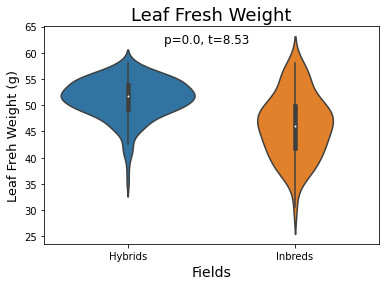

In [372]:
pval2 = 'p=%s, t=%s'  % (pval[0] , pval[1])
sns.violinplot(y= trait, x='Field Location', data=data)
xmin , xmax , ymin, ymax = plt.axis()
plt.text((xmax)/7, ymax*0.95, pval2, fontsize=12)
plt.title('Leaf Fresh Weight', fontsize=18)
plt.xlabel('Fields', fontsize=14)
plt.ylabel('Leaf Freh Weight (g)', fontsize=13)
plt.xticks(ticks=[0,1], labels=['Hybrids', 'Inbreds'])

In [332]:
sam_spectrum = data.loc[data['Field Location'] == 'SAM', :] #.iloc[: , data.columns.get_loc('350'): data.columns.get_loc('2500') +1]

In [333]:
sam_spectrum = sam_spectrum.iloc[: , sam_spectrum.columns.get_loc('350'): sam_spectrum.columns.get_loc('2500') + 1]

In [334]:
hips_spectrum = data.loc[data['Field Location'] == 'HIPS', :].iloc[: , data.columns.get_loc('350'): data.columns.get_loc('2500') +1]

Text(0, 0.5, 'Reflectance')

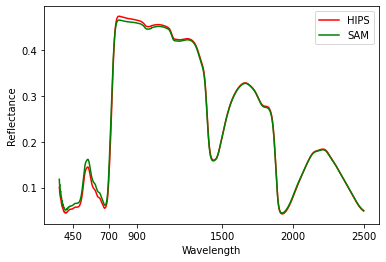

In [335]:
plt.plot(hips_spectrum.mean().T, color= 'r', label= 'HIPS')
plt.plot(sam_spectrum.mean().T, color= 'g', label = 'SAM')
plt.legend()
plt.xticks(ticks=['450', '700', '900', '1500', '2000', '2500'])
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

In [336]:
data['Field Location'].value_counts()

HIPS    216
SAM      68
Name: Field Location, dtype: int64

In [337]:
# selecting the source
data =data.loc[data['Source'] == 'GH' , :]

In [338]:
# Remove NaNs
data=data.loc[data[trait].notnull() , :]

In [339]:
data= data.loc[data['450'].notnull(), :]

In [340]:
y = data.loc[: , trait]

In [341]:
# identifying the X
position_350 = data.columns.get_loc('350')
position_2500 = data.columns.get_loc('2500') + 1 
X = data.iloc[:, position_350 : position_2500]

In [342]:
col_names=X.columns

In [343]:
X.shape

(281, 2151)

In [344]:
#applying savitzky golay
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns=col_names)

In [345]:
#drop first 100 column
X = X.drop(X.columns[0:100], axis=1)

In [346]:
#Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2055, 5)

In [347]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]

In [348]:
X.head()

,450,455,460,465,470,475,480,485,490,495,...,2455,2460,2465,2470,2475,2480,2485,2490,2495,2500
0,0.053652,0.055042,0.055857,0.055601,0.055264,0.055215,0.056182,0.056428,0.058073,0.060495,...,0.079264,0.076277,0.073711,0.071128,0.068609,0.066713,0.064766,0.062966,0.061157,0.059954
1,0.058169,0.059998,0.061030,0.061664,0.061849,0.062109,0.062616,0.063506,0.065533,0.069101,...,0.091355,0.088120,0.085164,0.082505,0.079846,0.077179,0.075231,0.072884,0.071422,0.069293
2,0.056875,0.057719,0.058697,0.058876,0.058923,0.058356,0.058692,0.059097,0.060661,0.062825,...,0.069376,0.066619,0.064146,0.061778,0.059736,0.057862,0.056117,0.054806,0.053429,0.051818
3,0.060520,0.061697,0.062635,0.063022,0.063029,0.063101,0.063390,0.063876,0.065190,0.067642,...,0.083531,0.081014,0.078316,0.076117,0.073774,0.071798,0.069882,0.068222,0.066663,0.065284
4,0.057057,0.058450,0.059313,0.059579,0.059548,0.059632,0.059885,0.060501,0.061867,0.064645,...,0.076214,0.073949,0.071496,0.069559,0.067203,0.065587,0.063719,0.062053,0.060914,0.059837


In [349]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.4)

In [350]:
y_test

473    46.933333
423    48.766667
455    56.066667
369    49.966667
349    49.733333
         ...    
430    52.233333
277    47.733333
165    52.100000
113    52.733333
389    50.633333
Name: SPADmeter, Length: 113, dtype: float64

In [351]:
y_test2 = pd.DataFrame(y_test)

In [352]:
index = y_test2.index

In [353]:
### calculate RMSE
pls = PLSRegression(n_components=17)
pls.fit(X_train, y_train)

PLSRegression(n_components=17)

In [354]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

2.887855772243224

In [355]:
y_pred = pls.predict(X_test)

In [356]:
y_pred = pd.DataFrame(y_pred, columns=['Predicted'])

In [357]:
y_pred.set_index(keys=index, drop=True, append=False, inplace=True)

In [358]:
gtvspred = pd.concat([y_test, y_pred], axis=1)

In [359]:
gtvspred

,SPADmeter,Predicted
473,46.933333,45.648684
423,48.766667,48.167678
455,56.066667,51.977536
369,49.966667,50.913360
349,49.733333,51.407875
...,...,...
430,52.233333,52.430877
277,47.733333,47.106063
165,52.100000,49.170935
113,52.733333,53.028386


In [360]:
foranalysis = pd.concat([data.loc[index, ['PLOT ID', 'Genotype']], gtvspred], axis=1)

In [361]:
foranalysis

,PLOT ID,Genotype,SPADmeter,Predicted
473,2109,Oh43@,46.933333,45.648684
423,6274,B37 x H95,48.766667,48.167678
455,1218,PHK76@,56.066667,51.977536
369,6210,PHK76 x LH145,49.966667,50.913360
349,6159,2FACC x 3IIH6,49.733333,51.407875
...,...,...,...,...
430,5152,B14A x Mo17,52.233333,52.430877
277,5268,B37 x H95,47.733333,47.106063
165,5131,F42 x Mo17,52.100000,49.170935
113,4260,LH123HT x 3IIH6,52.733333,53.028386


In [362]:
#export for heterosis calculation
foranalysis.to_csv('heterosis_in_gs1.csv')

In [363]:
data2 = pd.read_csv('heterosis_prediction_file.csv')

In [364]:
data2

,Hybrid,Observed Heterosis,Predicted Heterosis
0,2FACC x 3IIH6,17.063492,25.150766
1,B14A x Mo17,78.769018,40.798071
2,B37 x Mo17,28.478261,15.230531
3,B37 x OH43,-30.294906,-16.526290
4,B73 x 3IIH6,3.032659,9.741629
5,B73 x Mo17,-6.577975,9.557113
6,B73 x PHZ51,13.429952,-8.395925
7,B84 x 3IIH6,11.913357,10.014490
8,F42 x Mo17,17.481203,12.439531
9,F42 x OH43,-21.913203,-12.577348


In [365]:
from scipy.stats import pearsonr, spearmanr

r, p = spearmanr(data2['Observed Heterosis'], data2['Predicted Heterosis'])
r2 = r**2
text =r2, p
#text = [np.round(r2, 2) for r2 in text]
text =(np.round(r2,2), np.round(p,3))

Text(0.5, 1.0, 'Heterosis Prediction Accuracy \n for Fresh Leaf Weight')

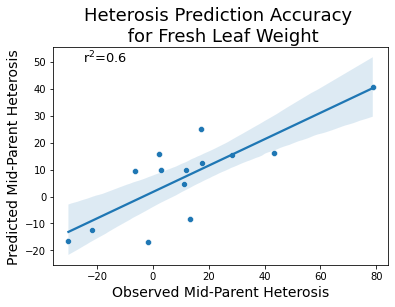

In [366]:
text1 = 'r$^2$=%s' % text[0]
sns.regplot(x='Observed Heterosis', y='Predicted Heterosis' , scatter_kws={'s' : 15}, data=data2)
xmin , xmax , ymin, ymax = plt.axis()
sns.scatterplot(x='Observed Heterosis', y='Predicted Heterosis', data=data2).text((-25), ymax*0.90, text1, fontsize=13)
plt.xlabel('Observed Mid-Parent Heterosis', fontsize=14)
plt.ylabel('Predicted Mid-Parent Heterosis', fontsize=14)
plt.title('Heterosis Prediction Accuracy \n for Fresh Leaf Weight', fontsize=18)

In [367]:
from scipy.stats import pearsonr, spearmanr
#y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred)
r2 = r**2
print(r2, p)

0.7155971508203322 4.393245215700084e-32


Text(0.5, 0, 'Ground truth Leaf Weight')

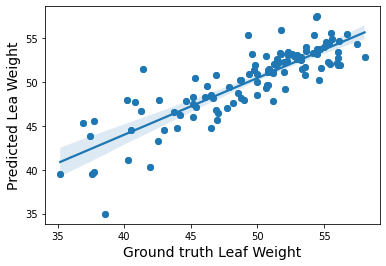

In [370]:
text2 = 'r$^2$=%s' % np.round(r2,2)
plt.scatter(y_test, y_pred)
sns.regplot(x = y_test , y = y_pred)#.text(2,12,text2, fontsize=14)
plt.ylabel('Predicted Lea Weight', fontsize=14)
plt.xlabel('Ground truth Leaf Weight', fontsize=14)



In [369]:
#reading the GS2 spectrum (without ground truth)
data = pd.read_csv('GS2_processed_spectrum.csv')a

SyntaxError: invalid syntax (<ipython-input-369-ee06822a3dad>, line 2)

In [ ]:
plotrep = data.loc[: , ['PLOT ID', 'Rep']]

In [ ]:
# identifying the X
position_350 = data.columns.get_loc('450')
position_2500 = data.columns.get_loc('2500') + 1 
X_test = data.iloc[:, position_350 : position_2500]

In [ ]:
### train a model with GS1 dataset calculate RMSE
pls = PLSRegression(n_components=11)
pls.fit(X , y)

In [ ]:
y_pred = pls.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(y_pred)

In [ ]:
y_pred = pd.concat([plotrep, y_pred], axis=1)

In [ ]:
y_pred.rename(columns={0 : trait + '_pred'}, inplace=True)

In [ ]:
y_pred

In [ ]:
#reading the GS2 ground truth
data_gs2_gt= pd.read_csv('GS2-gt.csv')

In [ ]:
data_gs2_gt

In [ ]:
gtvspred = pd.merge(data_gs2_gt,y_pred, how='outer')

In [ ]:
gtvspred

In [ ]:
# Calculate the spearman correlation , r2 and p value and pass them into the 'text'

from scipy.stats import pearsonr, spearmanr
#y_pred2 = [x[0] for x in data_plot.predicted]
r, p = spearmanr(gtvspred[trait], gtvspred[trait + '_pred'])
r2 = r**2
text =r2, p
text = [np.round(r2, 2) for r2 in text]

In [ ]:
#plot the results
text1 = 'r2=%s, p=%s' % (text[0], text[1])
sns.regplot(x=trait, y=trait + '_pred' , scatter_kws={'s' : 15}, data=gtvspred)
xmin , xmax , ymin, ymax = plt.axis()
sns.scatterplot(x=trait, y=trait + '_pred', data=gtvspred).text((xmax)/2, ymax*0.96, text1, fontsize=12)
#plt.xlabel('Ground Truth' + ' ' + trait)
#plt.ylabel('Predicted' + ' ' + trait + ' ' + 'Values')
#plt.title(trait + ' ' + 'PLSR'

In [ ]:
r2